In [3]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = r"C:\Users\Ray\Desktop\downloads\train_visualCheXbert.csv"
OUT_DIR = Path("eda_outputs")
OUT_DIR.mkdir(exist_ok=True)

# How many categories to print/plot for non-binary categorical columns
TOPK = 25

def is_binary_series(s: pd.Series) -> bool:
    """True if non-null unique values are subset of {0,1}."""
    if not pd.api.types.is_numeric_dtype(s):
        return False
    vals = set(pd.Series(s.dropna().unique()).astype(float).tolist())
    return vals.issubset({0.0, 1.0}) and len(vals) <= 2

def safe_filename(name: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", name)

def plot_bar_counts(counts: pd.Series, title: str, outpath: Path):
    plt.figure()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.savefig(outpath, bbox_inches="tight")
    plt.close()

def plot_hist(values: pd.Series, title: str, outpath: Path, bins=50):
    plt.figure()
    plt.hist(values, bins=bins)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.savefig(outpath, bbox_inches="tight")
    plt.close()

def main():
    df = pd.read_csv(CSV_PATH)
    print(f"Loaded: {CSV_PATH}")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} cols\n")

    # Store all distribution tables in a single Excel-like CSV bundle (one CSV per column)
    # (Keeping it simple: write individual CSVs)
    for col in df.columns:
        s = df[col]
        print("=" * 80)
        print(f"COLUMN: {col}")
        print(f"DTYPE:  {s.dtype}")
        missing_n = int(s.isna().sum())
        print(f"MISSING: {missing_n:,} ({missing_n/len(df):.3%})")

        col_safe = safe_filename(col)

        # --- PATH-LIKE (lots of uniques) ---
        if col.lower() == "path" or (s.dtype == "object" and s.nunique(dropna=True) > 5000):
            # 1) string length distribution
            lens = s.dropna().astype(str).map(len)
            print("\nPath/string length summary:")
            print(lens.describe())

            lens.to_frame("length").describe().to_csv(OUT_DIR / f"{col_safe}_length_describe.csv")
            plot_hist(lens, f"{col} length distribution", OUT_DIR / f"{col_safe}_length_hist.png", bins=50)

            # 2) top prefixes (first 3 folders)
            def prefix3(p):
                parts = str(p).split("/")
                return "/".join(parts[:3]) if len(parts) >= 3 else str(p)

            prefixes = s.dropna().astype(str).map(prefix3).value_counts().head(TOPK)
            print(f"\nTop {TOPK} prefixes (first 3 path segments):")
            print(prefixes)

            prefixes.to_csv(OUT_DIR / f"{col_safe}_top_prefixes.csv")
            plot_bar_counts(prefixes, f"{col} top prefixes (Top {TOPK})", OUT_DIR / f"{col_safe}_top_prefixes.png")
            continue

        # --- BINARY LABELS (0/1) ---
        if is_binary_series(s):
            counts = s.value_counts(dropna=False).sort_index()
            # ensure 0/1 order if present
            counts = counts.reindex([0.0, 1.0], fill_value=0).astype(int)

            prevalence = (s == 1).mean()
            print("\nBinary distribution (0/1 counts):")
            print(counts)
            print(f"Prevalence (mean of 1s): {prevalence:.4f}")

            counts.to_csv(OUT_DIR / f"{col_safe}_counts.csv")
            plot_bar_counts(counts, f"{col} (0/1 counts)", OUT_DIR / f"{col_safe}_counts.png")
            continue

        # --- NUMERIC (non-binary) ---
        if pd.api.types.is_numeric_dtype(s):
            print("\nNumeric summary:")
            print(s.describe())

            s.describe().to_frame().T.to_csv(OUT_DIR / f"{col_safe}_describe.csv", index=False)
            plot_hist(s.dropna(), f"{col} distribution", OUT_DIR / f"{col_safe}_hist.png", bins=50)
            continue

        # --- CATEGORICAL / TEXT (manageable uniques) ---
        vc = s.value_counts(dropna=False)
        nunique = s.nunique(dropna=True)

        print(f"\nUnique (non-null) values: {nunique:,}")
        top = vc.head(TOPK)
        print(f"\nTop {TOPK} value counts:")
        print(top)

        vc.to_csv(OUT_DIR / f"{col_safe}_value_counts_full.csv")
        top.to_csv(OUT_DIR / f"{col_safe}_value_counts_top{TOPK}.csv")
        plot_bar_counts(top, f"{col} top {TOPK} counts", OUT_DIR / f"{col_safe}_top_counts.png")

    print("\n✅ Done.")
    print(f"Outputs saved to: {OUT_DIR.resolve()}")

if __name__ == "__main__":
    main()


Loaded: C:\Users\Ray\Desktop\downloads\train_visualCheXbert.csv
Shape: 223,414 rows × 19 cols

COLUMN: Path
DTYPE:  object
MISSING: 0 (0.000%)

Path/string length summary:
count    223414.000000
mean         57.126944
std           0.332911
min          57.000000
25%          57.000000
50%          57.000000
75%          57.000000
max          58.000000
Name: Path, dtype: float64

Top 25 prefixes (first 3 path segments):
Path
CheXpert-v1.0/train/patient28746    92
CheXpert-v1.0/train/patient33155    92
CheXpert-v1.0/train/patient04462    89
CheXpert-v1.0/train/patient24163    86
CheXpert-v1.0/train/patient34615    85
CheXpert-v1.0/train/patient19317    80
CheXpert-v1.0/train/patient05702    79
CheXpert-v1.0/train/patient13011    79
CheXpert-v1.0/train/patient14282    77
CheXpert-v1.0/train/patient10970    76
CheXpert-v1.0/train/patient26381    76
CheXpert-v1.0/train/patient03122    76
CheXpert-v1.0/train/patient06028    76
CheXpert-v1.0/train/patient20479    75
CheXpert-v1.0/train/pati


=== Sex distribution (counts) ===
Sex
Male       132636
Female      90777
Unknown         1
Name: count, dtype: int64

=== Sex distribution (%) ===
Sex
Male       59.37
Female     40.63
Unknown     0.00
Name: count, dtype: float64


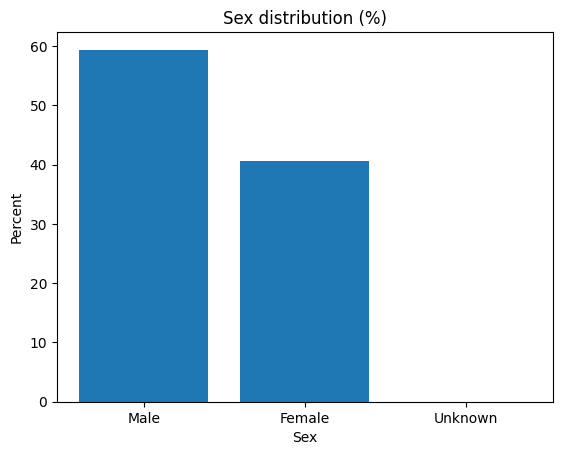


=== Age summary ===
count    223414.000000
mean         60.527662
std          17.995927
min           0.000000
25%          49.000000
50%          62.000000
75%          74.000000
max         110.000000
Name: Age, dtype: float64


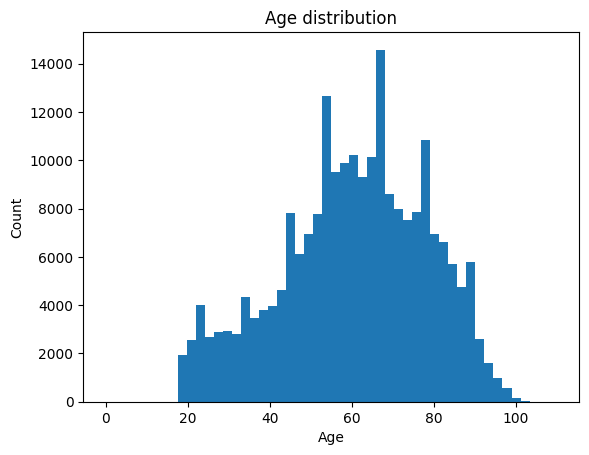


=== Age buckets (%) ===
Age
0-17      0.00
18-29     6.87
30-39     7.18
40-49    11.56
50-59    19.45
60-69    21.88
70-79    17.06
80-89    12.62
90+       3.39
Name: proportion, dtype: float64


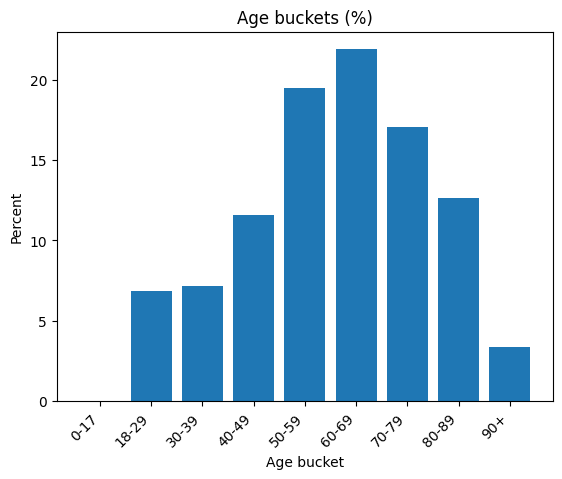


=== Frontal/Lateral (counts) ===
Frontal/Lateral
Frontal    191027
Lateral     32387
Name: count, dtype: int64

=== Frontal/Lateral (%) ===
Frontal/Lateral
Frontal    85.5
Lateral    14.5
Name: count, dtype: float64


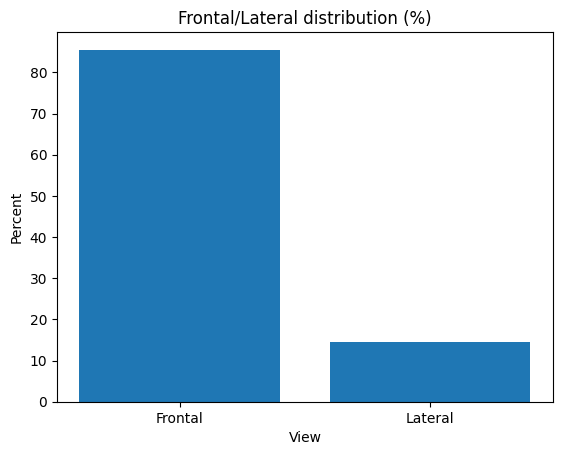


=== AP/PA/Empty (counts) ===
AP/PA
AP       161590
Empty     32387
PA        29420
LL           16
RL            1
Name: count, dtype: int64

=== AP/PA/Empty (%) ===
AP/PA
AP       72.33
Empty    14.50
PA       13.17
LL        0.01
RL        0.00
Name: count, dtype: float64


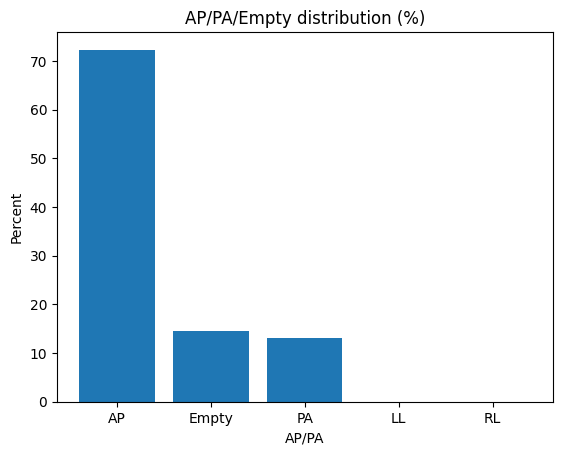


=== Label 0/1 distributions ===
                     Label  Count_0  Count_1  Missing  Prevalence_%_1
              Lung Opacity   143826   303002        0           67.81
Enlarged Cardiomediastinum   158888   287940        0           64.44
           Support Devices   174908   271920        0           60.86
               Atelectasis   198980   247848        0           55.47
              Cardiomegaly   202986   243842        0           54.57
             Consolidation   232370   214458        0           48.00
          Pleural Effusion   239528   207300        0           46.39
                     Edema   258088   188740        0           42.24
                  Fracture   323448   123380        0           27.61
                 Pneumonia   342376   104452        0           23.38
                No Finding   375776    71052        0           15.90
               Lung Lesion   384774    62054        0           13.89
             Pleural Other   394178    52650        0    

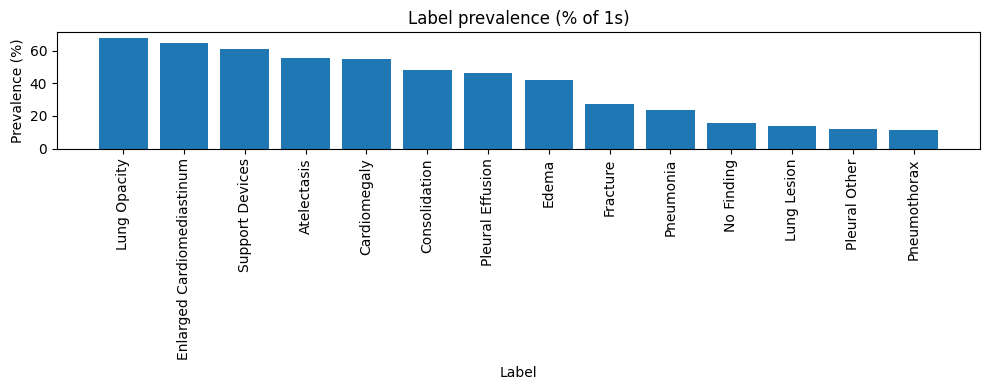

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = r"C:\Users\Ray\Desktop\downloads\train_visualCheXbert.csv"

# ----------------------------
# Load data
# ----------------------------
df = pd.read_csv(CSV_PATH)

# ----------------------------
# 1) Sex: % Male/Female
# ----------------------------
sex_counts = df["Sex"].fillna("Missing").value_counts()
sex_pct = (sex_counts / len(df) * 100).round(2)

print("\n=== Sex distribution (counts) ===")
print(sex_counts)
print("\n=== Sex distribution (%) ===")
print(sex_pct)

plt.figure()
plt.bar(sex_pct.index.astype(str), sex_pct.values)
plt.title("Sex distribution (%)")
plt.xlabel("Sex")
plt.ylabel("Percent")
plt.xticks(rotation=0)
plt.show()

# ----------------------------
# 2) Age distribution
# ----------------------------
print("\n=== Age summary ===")
print(df["Age"].describe())

plt.figure()
plt.hist(df["Age"].dropna(), bins=50)
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Optional: age bucket distribution (nice for reporting)
age_bins = [0, 18, 30, 40, 50, 60, 70, 80, 90, 120]
age_labels = ["0-17","18-29","30-39","40-49","50-59","60-69","70-79","80-89","90+"]
age_bucket = pd.cut(df["Age"], bins=age_bins, labels=age_labels, right=False)
age_bucket_pct = (age_bucket.value_counts(normalize=True).sort_index() * 100).round(2)

print("\n=== Age buckets (%) ===")
print(age_bucket_pct)

plt.figure()
plt.bar(age_bucket_pct.index.astype(str), age_bucket_pct.values)
plt.title("Age buckets (%)")
plt.xlabel("Age bucket")
plt.ylabel("Percent")
plt.xticks(rotation=45, ha="right")
plt.show()

# ----------------------------
# 3) Frontal/Lateral distribution
# ----------------------------
fl_counts = df["Frontal/Lateral"].fillna("Missing").value_counts()
fl_pct = (fl_counts / len(df) * 100).round(2)

print("\n=== Frontal/Lateral (counts) ===")
print(fl_counts)
print("\n=== Frontal/Lateral (%) ===")
print(fl_pct)

plt.figure()
plt.bar(fl_pct.index.astype(str), fl_pct.values)
plt.title("Frontal/Lateral distribution (%)")
plt.xlabel("View")
plt.ylabel("Percent")
plt.xticks(rotation=0)
plt.show()

# ----------------------------
# 4) AP/PA/Empty distribution
# ----------------------------
ap_counts = df["AP/PA"].fillna("Empty").value_counts()
ap_pct = (ap_counts / len(df) * 100).round(2)

print("\n=== AP/PA/Empty (counts) ===")
print(ap_counts)
print("\n=== AP/PA/Empty (%) ===")
print(ap_pct)

plt.figure()
plt.bar(ap_pct.index.astype(str), ap_pct.values)
plt.title("AP/PA/Empty distribution (%)")
plt.xlabel("AP/PA")
plt.ylabel("Percent")
plt.xticks(rotation=0)
plt.show()

# ----------------------------
# 5) 0/1 distributions for all label columns
# ----------------------------
label_cols = [
    "Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity","Lung Lesion","Edema",
    "Consolidation","Pneumonia","Atelectasis","Pneumothorax","Pleural Effusion",
    "Pleural Other","Fracture","Support Devices","No Finding"
]

rows = []
for c in label_cols:
    vc = df[c].value_counts(dropna=False)
    n0 = int(vc.get(0.0, 0) + vc.get(0, 0))
    n1 = int(vc.get(1.0, 0) + vc.get(1, 0))
    nmiss = int(df[c].isna().sum())
    prev = (df[c] == 1).mean() * 100
    rows.append([c, n0, n1, nmiss, round(prev, 2)])

label_dist = pd.DataFrame(
    rows,
    columns=["Label", "Count_0", "Count_1", "Missing", "Prevalence_%_1"]
).sort_values("Prevalence_%_1", ascending=False)

print("\n=== Label 0/1 distributions ===")
print(label_dist.to_string(index=False))

plt.figure(figsize=(10, 4))
plt.bar(label_dist["Label"], label_dist["Prevalence_%_1"])
plt.title("Label prevalence (% of 1s)")
plt.xlabel("Label")
plt.ylabel("Prevalence (%)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
